In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import copy

# init given linear layer m with given sw and sb
def init_weights(m, sw, sb):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
        nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
# TODO: activation function
# TODO: name the layers
def generate_fc_dnn(input_dim, output_dim, depth, width):
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    return nn.Sequential(*fc_list)

import torch.nn as nn

'''def generate_cnn(input_dim, output_dim, depth, num_channels):
    layers = []
    in_channels = 1  # Assuming grayscale input images

    # Convolutional layers
    for i in range(depth):
        layers.append(nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
        layers.append(nn.Tanh())
        
        # Add MaxPool2d layer every 2 convolutional layers
        if i % 2 == 1:
            layers.append(nn.MaxPool2d(2))
            input_dim = input_dim // 2
            print("input_dim: ", input_dim)
        
        in_channels = num_channels
        #num_channels *= 2

    # Flatten the output from convolutional layers
    layers.append(nn.Flatten())

    # Fully connected layer for classification
    layers.append(nn.Linear(in_channels * input_dim * input_dim, output_dim))
    layers.append(nn.LogSoftmax(dim=1))

    model = nn.Sequential(*layers)
    return model
'''

import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels):
        super(CustomCNN, self).__init__()

        in_channels = 1  # Assuming grayscale input images
        conv_count = 0
        pool_count = 0

        for i in range(depth):
            # Name the layers
            conv_name = f"conv{conv_count + 1}"
            act_name = f"tanh{conv_count + 1}"

            # Add convolutional layer
            setattr(self, conv_name, nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            # Add activation layer
            setattr(self, act_name, nn.Tanh())
            conv_count += 1

            # Add MaxPool2d layer every 2 convolutional layers
            if i % 2 == 1:
                pool_name = f"pool{pool_count + 1}"
                setattr(self, pool_name, nn.MaxPool2d(2))
                pool_count += 1
                input_dim = input_dim // 2
                print("input_dim: ", input_dim)
            
            in_channels = num_channels
            # num_channels *= 2

        # Add fully connected layer for classification
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_channels * input_dim * input_dim, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for i, layer in enumerate(self.children()):
            x = layer(x)
        return x

def generate_cnn(input_dim, output_dim, depth, num_channels):
    model = CustomCNN(input_dim, output_dim, depth, num_channels)
    return model

# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0],
                                         -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc


class MNISTtrainer(object):
    def __init__(self, batch_size):
        self.input_dim = 28 * 28
        self.output_dim = 10

        # rescale to [-.5, .5]
        self.loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)
        

class MNISTtrainerCNN(object):
    def __init__(self, batch_size):
        self.input_dim = (1, 28, 28)  # Channels x Height x Width
        self.output_dim = 10

        # rescale to [-.5, .5]
        self.loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

        
class FashionMNISTtrainer(object):
    def __init__(self, batch_size):
        self.input_dim = 28 * 28
        self.output_dim = 10

        # rescale to [-.5, .5]
        self.loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)


class FashionMNISTtrainerCNN(object):
    def __init__(self, batch_size):
        self.input_dim = (1, 28, 28)  # Channels x Height x Width
        self.output_dim = 10

        # rescale to [-.5, .5]
        self.loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)


# TODO: option to freeze some layers
# TODO: option to save the model?
def compute_training_acc(model, dataset, params, debug=False):

    device = torch.device(params['device'])
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.loader):
        data, target = data.reshape([data.shape[0],
                                     -1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if debug and batch_idx % 20 == 0:
            print('Train step: {} \tLoss: {:.6f}'.format(
                batch_idx, loss.item()))
        if (batch_idx == params['num_train']):
            train_acc = eval(model, device, dataset.loader, debug)
            break

    return train_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.loader, debug)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.loader, debug)
    return train_acc, model

def eval_cnn(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    return acc

def compute_training_acc_epochs_cnn(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.loader, debug)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval_cnn(model, device, dataset.loader, debug)
    return train_acc, model



# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, cut_point=1, freeze=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers) // 2):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]

        # Apply initialization
        init_weights(linear_layer, sw, sb)

        # Append to new layers
        new_layers.extend([linear_layer, activation])

    # Return new model
    return nn.Sequential(*new_layers)

def cut_cnn_model(model, cut_point=1, freeze=True):
    """
    Cut the CNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (nn.Module): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (nn.Sequential): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers):
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers)):
        layer = layers[i]
        
        # Reinitialize weights if layer has parameters (like Conv2d)
        if hasattr(layer, 'weight'):
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        
        # Append to new layers
        new_layers.append(layer)

    # Return new model
    return nn.Sequential(*new_layers)


# Replicate the pretrained model, cut at each layer and fine-tune, 
# return a list of accuracies (and some more results) for each layers.
def calculate_cut_accuracies(model, sw, sb, dataset, params):
    train_accuracies = []
    for i, layer in enumerate(model.layers):
        model_tmp = cut_model(model, sw, sb, cut_point=i)
        # TODO: don't forget to freeze the layers
        acc, model_tmp_fine_tuned = compute_training_acc(dataset, params, debug=False)
        train_accuracies.append(acc)
    return train_accuracies

# TODO: Add other util functions: plotting training etc

### Baseline, end to end trained model

In [6]:
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
depth = 7

#TODO: the CNN code does not initialize the weights with sw and sb
fashion_dataset = FashionMNISTtrainerCNN(batch_size)
params = dict(device=device,
                width=50, lr=0.01, num_train=4,
                sb=1, depth= depth, sw=1.5)

fashion_model = generate_cnn(fashion_dataset.input_dim[1], fashion_dataset.output_dim,
                params['depth'], params['width']).to(device)

pretrain_acc, pre_trained_model = compute_training_acc_epochs_cnn(fashion_model, fashion_dataset, params, debug=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 6712089.51it/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 56263.57it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 466440.01it/s] 


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2713620.33it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

input_dim:  14
input_dim:  7
input_dim:  3
CustomCNN(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh1): Tanh()
  (conv2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh2): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh3): Tanh()
  (conv4): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh4): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh5): Tanh()
  (conv6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh6): Tanh()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(50, 50, ke

Layer conv1 - Variance: 0.02514982596039772
Layer tanh1 - Variance: 0.02188011258840561
Layer conv2 - Variance: 0.04550836235284805
Layer tanh2 - Variance: 0.03694343566894531
Layer pool1 - Variance: 0.0353788360953331
Layer conv3 - Variance: 0.06672688573598862
Layer tanh3 - Variance: 0.049337148666381836
Layer conv4 - Variance: 0.11918425559997559
Layer tanh4 - Variance: 0.0839008167386055
Layer pool2 - Variance: 0.07938072085380554
Layer conv5 - Variance: 0.08529820293188095
Layer tanh5 - Variance: 0.063873790204525
Layer conv6 - Variance: 0.07532480359077454
Layer tanh6 - Variance: 0.05920710414648056
Layer pool3 - Variance: 0.055222827941179276
Layer conv7 - Variance: 0.028896622359752655
Layer tanh7 - Variance: 0.025996429845690727
Layer flatten - Variance: 0.025996429845690727
Layer fc - Variance: 15.57133960723877
Layer logsoftmax - Variance: 18.950469970703125


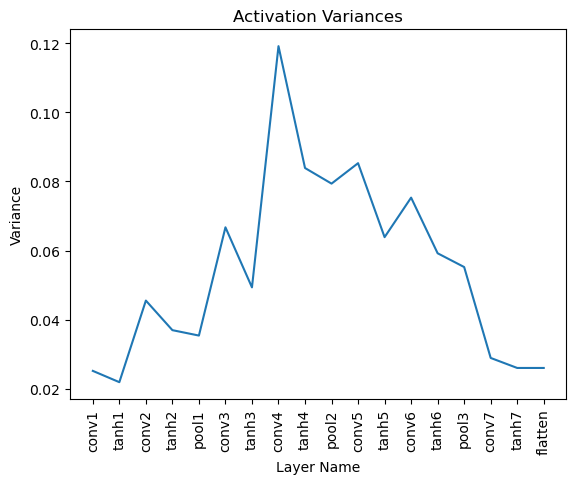

In [7]:
def compute_layer_variances(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            layer.register_forward_hook(create_hook(name))

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)

    # Calculate and print variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}
    
    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = variance.mean().item()

    return result, variances

# Usage:
results, variances = compute_layer_variances(fashion_model, fashion_dataset.loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")
    
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


/tmp/ipykernel_28/2887497188.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/tmp/ipykernel_28/2887497188.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)
/tmp/ipykernel_28/2887497188.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(pool_layer_names, rotation=90)


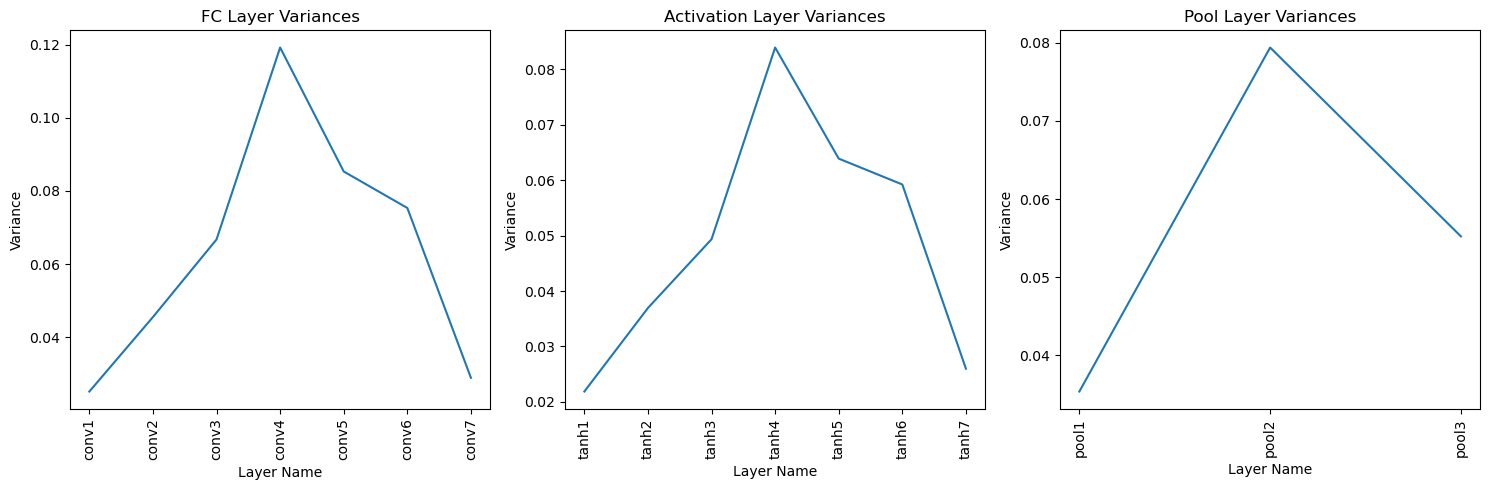

In [10]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'conv' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'conv' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'tanh' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'tanh' in name]

# Create a list of layer names and variances for pool layers
pool_layer_names = [name for name in variances.keys() if 'pool' in name]
pool_variance_values = [variance.mean().item() for name, variance in variances.items() if 'pool' in name]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the variances for fc layers
axs[0].plot(conv_layer_names, conv_variance_values)
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Variance')
axs[0].set_title('FC Layer Variances')

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values)
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Variance')
axs[1].set_title('Activation Layer Variances')

# Plot the variances for pool layers
axs[2].plot(pool_layer_names, pool_variance_values)
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Variance')
axs[2].set_title('Pool Layer Variances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### finetuned staring from fashion mnist to number mnist

In [5]:
#luckily, the number of classes is the same, so we don't need to change the last layer.

number_dataset = MNISTtrainerCNN(batch_size)

cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_cnn_model(fashion_model, cut_point = cut, freeze = True)
    finetuned_acc, finetuned_model = compute_training_acc_epochs_cnn(temp['cut_model'], number_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

100%|██████████| 9912422/9912422 [00:00<00:00, 135295321.92it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 72973309.53it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46130237.90it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7669295.00it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.9739833333333333
Cut 1:
0.97025
Cut 2:
0.9665833333333333
Cut 3:
0.9732666666666666
Cut 4:
0.9734333333333334
Cut 5:
0.9691666666666666
Cut 6:
0.9686666666666667


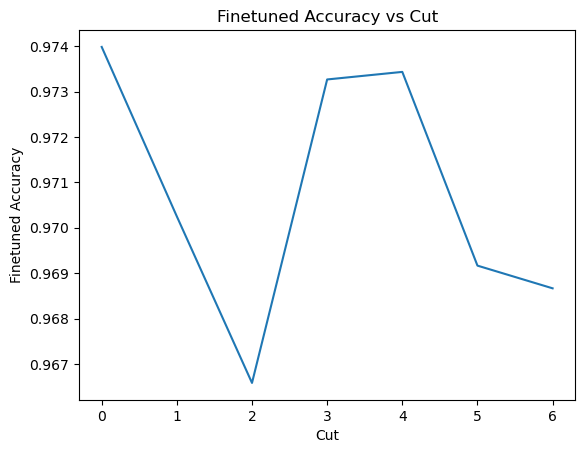

In [9]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

----

In [ ]:
dataset = MNISTtrainer(args.batch_size)
params = dict(device='cpu' if args.no_cuda else 'cuda',
                width=args.width, lr=args.lr, num_train=args.num_train,
                sb=0.05,
    )
if args.debug: print(params)

# run experiment in grid coordinate.
sws = np.linspace(1., 4., args.num_sw)

# test a lot less depths
depths = np.linspace(10, 100, args.num_depth, dtype=int)

pretrain_accs = list()
all_cut_accuracies = list()

for i, depth in enumerate(depths):
    for j, sw in enumerate(sws):
        params['depth'], params['sw'] = depth, sw
        
        # build and initialize the DNN model and optimizer
        model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                        params['depth'], params['width']).to(device)
        
        pretrain_acc, pre_trained_model = compute_training_acc(model, dataset, params, debug=False)
        cut_accuracies = calculate_cut_accuracies(model, sw, sb, dataset, params)
        all_cut_accuracies.append(cut_accuracies)
        
        acc = compute_training_acc(dataset, params, debug=args.debug_train_acc)
        pretrain_accs.append(pretrain_acc)
        
        if args.debug: print('({},{})->[d={},sw={}]: \t Train Acc: {:.6f}'.format(i,j,depth,sw,acc))

# acc = np.array(accs).reshape((len(depths), len(sws)))
# np.savez('train_acc', xgrid=sws,ygrid=depths,train_acc=acc)